# VIS: Model \#2
## Siamese Fusion Discrimination Network for Video-Audio Matching

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/MIT6-8300_Computer_Vision/Visually-Indicated-Sounds/

/content/drive/MyDrive/MIT6-8300_Computer_Vision/Visually-Indicated-Sounds


In [3]:
import os
import time

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import copy as copy

from dataloader import VideoAudioDataset

from constants import AUDIO_SAMPLE_RATE

# !! Put data file location in file `data_filepath`
# If file `data_filepath` does not exist, assume data is located in root
filepath = 'vis-data-256/vis-data-256/'

if os.path.isfile('data_filepath'):
    with open('data_filepath', 'r') as f:
        filepath = f.readline() + filepath

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print("Active device: ", device)

Active device:  cuda


## Model structure

In [4]:
class FusionVIS(nn.Module):
    def __init__(self):
        super(FusionVIS, self).__init__()

        # audio preprocessing
        self.audio_preprocess = nn.Sequential(
            MelSpectrogram(sample_rate=AUDIO_SAMPLE_RATE, n_fft=2048, hop_length=512, n_mels=128),
            AmplitudeToDB()
        )

        # resnet backbone
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.backbone.fc = nn.Identity()

        # define convolutional layers
        # self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        # self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        # self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # video

        # define fully connected layers
        self.fc1 = nn.Linear(in_features=1024, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=1)

    def forward(self, video, audio):
        with torch.no_grad():

          batch_size, seq_len, c, h, w = video.size()
          video = video.view(batch_size*seq_len, c, h, w)

          # audio preprocessing
          batch_size, samples = audio.size()
          spectrogram = self.audio_preprocess(audio)
          spec_3 = spectrogram.unsqueeze(1).repeat(1, 3, 1, 1) # Don't forget to unsqueeze(1) to keep batch_size!

          # backbone
          video = self.backbone(video)
          audio_feat = self.backbone(spec_3)
          
          # print("Audio postprocessing: (nothing to do)")
          # print(audio_feat.shape)

          # print("Video postprocessing:")
          # print(video.shape)
          video = video.reshape(batch_size, seq_len, -1) # This is debatable: we are forcing (batch_size ,X) from arbitrary shape - labels are mixed??
          # print(video.shape)
          video_feat = torch.max(video, dim=1)[0]
          # print(video_feat.shape)

          # concatenation
          # print("Final concat:")
          # print(video_feat.shape)
          # print(audio_feat.shape)
          fusion = torch.cat([video_feat, audio_feat], dim=1)

        fusion = self.fc1(fusion)
        fusion = F.relu(fusion)
        fusion = self.fc2(fusion)
        fusion = F.relu(fusion)
        fusion = self.fc3(fusion)
        fusion = F.sigmoid(fusion)

        return fusion.squeeze()

In [5]:
fusion_model = FusionVIS().to(device)

## Training

In [6]:
RANDOM_SEGMENT_SECONDS = 5

N_EPOCHS = 5
TRAIN_DATASET_SUBSAMPLE_SIZE = 780
VAL_DATASET_SUBSAMPLE_SIZE = 96
TEST_DATASET_SUBSAMPLE_SIZE = 96
BATCH_SIZE = 4

# Dataset setup

train_filenames_bug = np.load('datasets/train_dataset.npy')
val_filenames = np.load('datasets/val_dataset.npy')
test_filenames = np.load('datasets/test_dataset.npy')

train_filenames = np.array([0, 0, 0])

for fn in train_filenames_bug:
  if fn[1] != '2015-09-12-04-15-35-1_mic.wav':
    train_filenames = np.vstack((train_filenames, fn))

train_filenames = train_filenames[1:,]

train_filenames = train_filenames[:TRAIN_DATASET_SUBSAMPLE_SIZE,]
val_filenames = val_filenames[:VAL_DATASET_SUBSAMPLE_SIZE,]
test_filenames = test_filenames[:TEST_DATASET_SUBSAMPLE_SIZE,]

print("Training set size: ", train_filenames.shape)
print("Validation set size: ", val_filenames.shape)
print("Test set size: ", test_filenames.shape)

train_dataset = VideoAudioDataset(train_filenames, device, filepath_prefix=filepath, transform=VideoAudioDataset.Transform.RANDOM_SEGMENT, random_segment_seconds=RANDOM_SEGMENT_SECONDS)
val_dataset = VideoAudioDataset(val_filenames, device, filepath_prefix=filepath, transform=VideoAudioDataset.Transform.RANDOM_SEGMENT, random_segment_seconds=RANDOM_SEGMENT_SECONDS)
test_dataset = VideoAudioDataset(test_filenames, device, filepath_prefix=filepath, transform=VideoAudioDataset.Transform.RANDOM_SEGMENT, random_segment_seconds=RANDOM_SEGMENT_SECONDS)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) # We shuffle the training set
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Training set size:  (780, 3)
Validation set size:  (96, 3)
Test set size:  (96, 3)


In [7]:
dataloaders = {'train':train_loader, 'val':val_loader}

criterion = nn.BCELoss()
optimizer= optim.Adam(fusion_model.parameters(), lr=0.001)

since = time.time()

train_arr_loss = []
train_arr_acc = []
val_arr_loss = []
val_arr_acc = []

best_model_wts = copy.deepcopy(fusion_model.state_dict())
best_acc = 0.0

for epoch in range(N_EPOCHS):

  print('Epoch {}/{}'.format(epoch + 1, N_EPOCHS))
  print('-' * 10)

  for phase in ['train', 'val']:

    if phase == 'train':
      fusion_model.train()
    else:
      fusion_model.eval()

    c_loss = 0.0
    c_total = 0
    c_corrects = 0

    loader = dataloaders[phase]

    for video_feat, audio_feat, label in tqdm(dataloaders[phase]):
      video_feat = video_feat.to(device)
      audio_feat = audio_feat.to(device)
      label = label.to(device)

      optimizer.zero_grad()

      with torch.set_grad_enabled(phase == 'train'):

        output = fusion_model(video_feat, audio_feat)
        loss = criterion(output, label.float())

        pred = torch.round(output)

        if phase == 'train':
          loss.backward()
          optimizer.step()

      c_loss += loss.item()
      c_total += label.size(0)
      c_corrects += (pred == label).sum().item()

      torch.cuda.empty_cache()

    epoch_loss = c_loss / len(dataloaders[phase].dataset)
    epoch_acc = 1.0*c_corrects / len(dataloaders[phase].dataset)

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    if phase == 'val' and epoch_acc > best_acc:
      best_acc = epoch_acc
      best_model_wts = copy.deepcopy(fusion_model.state_dict())
    if phase == 'train':
      train_arr_loss.append(epoch_loss)
      train_arr_acc.append(epoch_acc)
    if phase == 'val':
      val_arr_loss.append(epoch_loss)
      val_arr_acc.append(epoch_acc)

  print()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))

Epoch 1/5
----------


  0%|          | 0/195 [00:00<?, ?it/s]

train Loss: 0.1338 Acc: 0.7179


  0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.2093 Acc: 0.4167

Epoch 2/5
----------


  0%|          | 0/195 [00:00<?, ?it/s]

train Loss: 0.0784 Acc: 0.8731


  0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.2097 Acc: 0.4479

Epoch 3/5
----------


  0%|          | 0/195 [00:00<?, ?it/s]

train Loss: 0.0821 Acc: 0.8667


  0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.1891 Acc: 0.5312

Epoch 4/5
----------


  0%|          | 0/195 [00:00<?, ?it/s]

train Loss: 0.0861 Acc: 0.8436


  0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.2426 Acc: 0.5000

Epoch 5/5
----------


  0%|          | 0/195 [00:00<?, ?it/s]

train Loss: 0.0729 Acc: 0.8897


  0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.1875 Acc: 0.5625

Training complete in 81m 58s
Best val Acc: 0.562500


In [8]:
# RENAME SAVE FILE AFTER SAVE!
torch.save(best_model_wts, 'model_weights/weights_best_val_acc.pt')
np.save('model_logs/loss_acc_logs/train_arr_loss.npy', train_arr_loss)
np.save('model_logs/loss_acc_logs/train_arr_acc.npy', train_arr_acc)
np.save('model_logs/loss_acc_logs/val_arr_loss.npy', val_arr_loss)
np.save('model_logs/loss_acc_logs/val_arr_acc.npy', val_arr_acc)

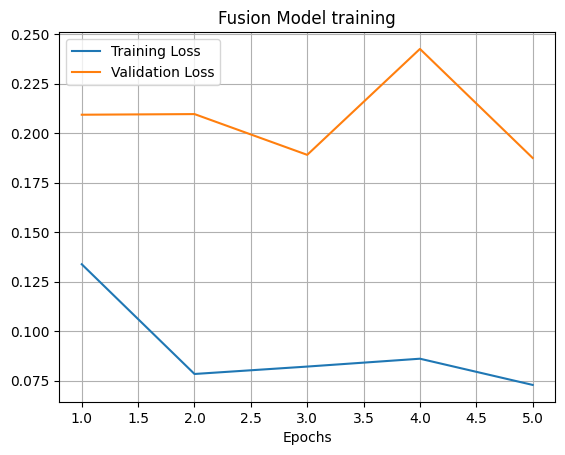

In [9]:
plt.plot(range(1,N_EPOCHS+1),train_arr_loss, label="Training Loss")
plt.plot(range(1,N_EPOCHS+1),val_arr_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.legend()
plt.grid()
plt.title("Fusion Model training")
plt.show()

In [11]:
torch.cuda.empty_cache()

In [7]:
fusion_model.load_state_dict(torch.load('model_weights/fusion_1_weights.pt'))

<All keys matched successfully>

In [8]:
fusion_model.eval()

correct = 0
total = 0

with torch.no_grad():
  for video_feat, audio_feat, label in tqdm(test_loader):
    video_feat = video_feat.to(device)
    audio_feat = audio_feat.to(device)
    label = label.to(device)
    output = fusion_model(video_feat, audio_feat)
    pred = torch.round(output)
    total += label.size(0)
    correct += (pred == label).sum().item()
    torch.cuda.empty_cache()

print(f"Accuracy on {total} test samples: {correct/total}")

  0%|          | 0/24 [00:00<?, ?it/s]

Accuracy on 96 test samples: 0.406


## Misc.